In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

/home/miguel/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/miguel/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [4]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt'], entrystop=3e6,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt'], entrystop=3e6,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    print('Dataframe has a total of ', df.shape[0], ' entries')
    print('####################################################################')

    return df


In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [6]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)

    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    temp.eval('jet_dphi = 3.14159265359 -abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt<150.0', 'jet pT < 150 GeV')

    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.5', 'jet eta > -1.5')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.75', 'jet eta < 2.75')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)

        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = 3.14159265359- abs(gene_phi-genjet_phi)',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [7]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Django'
altmc_name = 'Rapgap'

In [8]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

In [9]:
#path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'
#path = '/data0/users/marratia/HERAdata/out_ep0607/'

path = '/home/miguel/data/hera/'
data = get_Dataframe(path, name='Data', tag=data_tag)

filename is /home/miguel/data/hera/Data_Eplus0607_0.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_2.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_3.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_1.nominal.root
[b'Data;1']
####################################################################
Dataframe has a total of  371425  entries
####################################################################


In [10]:
%%time
bkg = get_Dataframe(path, name='DjBkgd', tag=data_tag)

filename is /home/miguel/data/hera/DjBkgd_0607_6.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_25.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_14.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_18.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_17.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_12.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_7.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_11.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_4.nominal.root
[]
could not find DjBkgd, skipping
filename is /home/miguel/data/hera/DjBkgd_0607_1.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_3.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_19.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_20.nominal.ro

In [11]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_121.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_151.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_7.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_3.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_116.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_126.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_132.nominal.root
[b'Django;1']
filename is

In [20]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_4.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_136.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_112.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_144.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_150.nominal.root
[b'Rapgap;1']
filename

## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [21]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['gen_Q2']>0, 1, 0)

data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)
bkg['pass_reco'] = np.where(bkg['jet_pt']>0, 1, 0)

CPU times: user 1.14 s, sys: 576 ms, total: 1.72 s
Wall time: 1.35 s


In [13]:
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)
bkg['pass_reco'] = np.where(bkg['jet_pt']>0, 1, 0)

In [15]:
%%time 

print('Selecting data events\n')
data = applyCutsJets(data)
bkg = applyCutsJets(bkg)

Selecting data events

0.08 < y < 0.7 260410  fraction kept: 100.0
Q2>150 260410  fraction kept: 100.0
jet pT > 5 GeV 260410  fraction kept: 100.0
jet pT < 150 GeV 260410  fraction kept: 100.0
jet eta > -1.5 260410  fraction kept: 100.0
jet eta < 2.75 260410  fraction kept: 100.0
0.08 < y < 0.7 18655464  fraction kept: 100.0
Q2>150 18565017  fraction kept: 99.5
jet pT > 5 GeV 18565017  fraction kept: 100.0
jet pT < 150 GeV 18565017  fraction kept: 100.0
jet eta > -1.5 18565017  fraction kept: 100.0
jet eta < 2.75 18565012  fraction kept: 100.0
CPU times: user 7.16 s, sys: 7.01 s, total: 14.2 s
Wall time: 12.4 s


In [22]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting MC events

0.08 < y < 0.7 88399799  fraction kept: 97.9
Q2>150 85738768  fraction kept: 97.0
jet pT > 5 GeV 85738768  fraction kept: 100.0
jet pT < 150 GeV 85738766  fraction kept: 100.0
jet eta > -1.5 85738743  fraction kept: 100.0
jet eta < 2.75 85738074  fraction kept: 100.0
 pass_truth>0 22290369  fraction kept: 26.0
Selecting MC events

0.08 < y < 0.7 73469803  fraction kept: 97.6
Q2>150 71412184  fraction kept: 97.2
jet pT > 5 GeV 71412184  fraction kept: 100.0
jet pT < 150 GeV 71412184  fraction kept: 100.0
jet eta > -1.5 71412167  fraction kept: 100.0
jet eta < 2.75 71411648  fraction kept: 100.0
 pass_truth>0 71411648  fraction kept: 100.0
CPU times: user 1min 11s, sys: 44 s, total: 1min 55s
Wall time: 1min 32s


In [ ]:
plt.hist(mc.query('pass_reco==1')['y'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1),bins=100,**plot_style_1,label='reco y')
plt.hist(data['y'],range=(0,1),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

In [ ]:
plt.hist(mc.query('pass_reco==1')['jet_dphi'],weights = mc.query('pass_reco==1')['wgt'], range=(np.pi/2.0,np.pi),bins=100,**plot_style_1,label='reco y')
plt.hist(data['jet_dphi'],range=(np.pi/2.0,np.pi),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

In [ ]:
plt.hist(mc.query('pass_reco==1')['genjet_dphi'],weights = mc.query('pass_reco==1')['wgt'], range=(np.pi/2.0,np.pi),bins=100,**plot_style_1,label='reco y')
plt.legend()
plt.show()

In [ ]:
plt.hist(mc.query('pass_reco==1')['genjet_z'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1.5),bins=100,**plot_style_1,label='reco y')
plt.hist(mc.query('pass_reco==1')['jet_z'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1.5),bins=100,**plot_style_1,label='reco y')

plt.legend()
plt.show()

## Check background

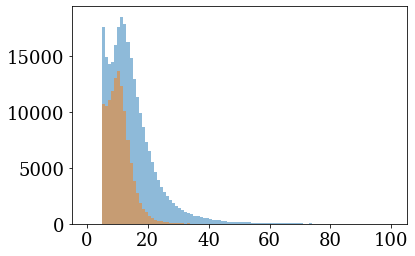

In [19]:
plt.hist(data['jet_pt'],range=(0,100),bins=100, **plot_style_2A, label='data')
plt.hist(bkg.query('pass_reco==1')['jet_pt'],range=(0,100),weights = bkg.query('pass_reco==1')['wgt'],bins=100, **plot_style_2A, label='data')
#plt.yscale('log')
plt.show()

## Event selection

In [ ]:
label_DISselection = r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$'

In [ ]:
data.head()

In [ ]:
mc.head()

### Define UniFold Algorithm


In [ ]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim=None,weights_MC_data=None,verbose=1):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(theta0_S))
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    history = {}
    history['step1'] = []
    history['step2'] = []
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=10000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        
        hist_s1 =  model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step1'].append(hist_s1)
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        hist_s2 = model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step2'].append(hist_s2)

        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model, history

    




In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

## Define features with data

In [ ]:
data_cut = data
n = int(len(data_cut)*30)
mc_cut = mc[:n]


print(len(mc_cut))
print(len(data_cut))

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
ratio = len(mc_cut.query('pass_reco==1'))/len(data_cut)
print(ratio)

In [ ]:
mc_cut.keys()

In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']


weight_MC = mc_cut['wgt']
# Q_0_G           = mc_cut['gen_Q']
# Q_0_S           = mc_cut['Q']
# Q_unknown_S     = data_cut['Q']

In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10



In [ ]:
bins = np.linspace(-20,20,400)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

#bins = np.linspace(-180,180, 101)
#bins = np.linspace(0,2, 101)
bins = np.linspace(-20,20,400)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1],bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

In [ ]:
plt.hist(jetdphi_unknown_S,bins=100, histtype='step',label='unknown')
#plt.hist(jetdphi_0_S,bins=100, histtype='step',label='epx_S')
#plt.hist(jetdphi_0_G,bins=100, histtype='step',label='epx_G')
plt.legend()
plt.show()
plt.hist(jetdphi_unknown_S,bins=100, histtype='step')
plt.hist(jetdphi_0_S,bins=100, histtype='step')
plt.hist(jetdphi_0_G,bins=100, histtype='step')
plt.show()

## Run unfolding on data

In [ ]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [ ]:
%%time 
iterations =5# use ~4 iterations
num_observables= 8
K.clear_session()
weights, _, history = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,weights_MC_sim =weight_MC,verbose=1)

In [ ]:
#list all data in history
# summarize history for accuracy
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train')
    ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
    ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')

    ax[0].legend()

In [ ]:
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train')
    ax[0].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
    ax[1].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')

    ax[0].legend()

## Incorporate weights into the dataframe

In [ ]:
mc_cut['weight_reco'] =  weights[-2, 0, :]
mc_cut['weight_truth'] = weights[-2, 1, :]

In [ ]:
mc_cut['weight_reco_next'] = weights[-1, 0, :]
mc_cut['weight_truth_next'] = weights[-1, 1, :]

mc_cut['weight_reco_previous'] =  weights[-3, 0, :]
mc_cut['weight_truth_previous'] = weights[-3, 1, :]


## Check weights

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_previous']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco_previous']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_next']),range=(-10,10),bins=100,**plot_style_2,label='Weight truth next')
plt.hist(np.log10(mc_cut['weight_reco_next']),range=(-10,10),bins=100,**plot_style_2, label='Weight reco next')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

#for i in range(len(weights)):
    #print ('Iteration %i'%i)
    #print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    #print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    #print(' ')

In [ ]:
print(len(mc_cut))

mc_cut = mc_cut.query('weight_reco<1e4 and weight_reco>1e-3')
mc_cut = mc_cut.query('weight_truth<1e4 and weight_truth>1e-3')
print(len(mc_cut))

In [ ]:
mc_cut = mc_cut.query('weight_reco_next<1e3 and weight_reco_next>1e-3')
mc_cut = mc_cut.query('weight_truth_next<1e3 and weight_truth_next>1e-3')

mc_cut = mc_cut.query('weight_reco_previous<1e3 and weight_reco_previous>1e-3')
mc_cut = mc_cut.query('weight_truth_previous<1e3 and weight_truth_previous>1e-3')

In [ ]:
fig, ax = plt.subplots(2,
                           3,
                           figsize=(15, 15),
                           constrained_layout=True)
ax = ax.flatten()
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)
    
    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

In [ ]:
mc_cut.keys()

## MC at reco level reweighted vs data

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = 'Data reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'],bins=bins, weights= mc_cut.query(query)['wgt'],label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3.5,25 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')
    ax[4].set_yscale('log')

   
    bins = np.linspace(0,100,50)

    ax[5].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['e_pt'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-np.pi,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['jet_phi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['jet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(data_cut.query(query)['jet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(np.pi/2.0,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['jet_dphi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/RealDataMC_comparison_inclusivejet_%i_iter_%s_%s_%s_data_%s.png'%(i,mc_name,mc_tag,period,data_tag)) 
    
    

## Plot unfolded results

In [ ]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
# ##track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    ax = ax.flatten()
    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(0,2,20 )

    
    ax[3].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(-1.5,3,25 )

    ax[4].set_xlabel(r'$jet eta $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['genjet_eta'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    
    bins = np.linspace(0,100,25)

    ax[5].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gene_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

## define binning

In [ ]:
qtbins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
qtbins[0] = 0.0
print (qtbins)

## Jet pT spectrum data reco vs MC reco

In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),15)
#bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, 
         label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetpt_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[0] = 0.0
print (bins)
plt.hist(mc_cut.query(query)['jet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' wgt.',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'$q_{T}/Q $ ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')


fig.savefig('figures/RealDataMC_jetqtnorm_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
#bins = np.logspace(np.log10(5),np.log10(100),20)
#bins = np.array([5,10,14,21,29,47,71,127])
bins = np.linspace(np.pi/2.0,np.pi,50)
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_dphi'], bins=bins,  weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'Lepton-jet $\Delta\phi$ [rad]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_dphi_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.linspace(0,1,20)

plt.hist(mc_cut.query(query)['y'], bins=bins, weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['y'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
#plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'y ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/DataMC_y_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
print(len(mc_cut['y']))
print(len(mc_cut.query('pass_reco==1')['y']))

In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(0,1,40)

plt.hist(mc_cut.query('pass_reco==1')['y'], weights = mc_cut.query('pass_reco==1')['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
plt.hist(mc_cut.query('pass_reco==1')['gen_y'],weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
plt.hist(mc_cut['gen_y'], bins=bins, weights = mc_cut['wgt'],label=mc_name+' truth', **plot_style_1A)


plt.legend()

In [ ]:
mc.keys()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
bins = np.linspace(0,50,100)

ax[0].hist(mc_cut['jet_pt'], weights = mc_cut['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[0].hist(mc_cut.query('pass_reco==1')['genjet_pt'],  weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[0].hist(mc_cut['genjet_pt'], weights = mc_cut['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[0].set_xlabel('jet $p_{T}$ [GeV]')
bins = np.linspace(-3.0,3.0,100)

ax[1].hist(mc_cut['jet_eta'], weights = mc_cut['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[1].hist(mc_cut.query('pass_reco==1')['genjet_eta'],  weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[1].hist(mc_cut['genjet_eta'], weights = mc_cut['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[1].set_xlabel('jet $\eta$ ')

ax[1].set_ylabel('Weighted entries')
ax[0].set_ylabel('Weighted entries')

ax[0].legend()

fig.savefig('figures/TruthReco_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


## Data/MC agreement with differential 

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(np.pi/2.0,np.pi,25)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], weights=mc_cut.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 15}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f < Q < %2.0f$ GeV'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/RealDataMCcomparison_dphi_diff_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),40)

plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted', color='black', histtype='step', lw=2
               )

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               color=color2, alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin ')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  



In [ ]:
altmc_cut = altmc

## Define fiducial region of the measurement

In [ ]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'


## Plot data, and unfolded results and MC truth

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(10),np.log10(100),7)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_pt'],weights = mc_cut.query(cut)['wgt'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],weights = altmc_cut.query(cut)['wgt'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $p_{T}$ [GeV]',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))

cut = fiducialregion
bins = np.linspace(-1,2.5,7)
plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_eta'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)



#plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $\eta_{lab}$ ',fontsize=22)


fig.savefig('figures/Unfolded_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[0] = 0.0
plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$q_{T}$/$Q$ ',fontsize=22)

plt.yscale('log')
#plt.xscale('log')
fig.savefig('figures/Unfolded_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
bins = np.geomspace(np.pi,2*np.pi,20) - np.pi
bins[0] = 0
print(bins)

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.linspace(np.pi/2.0,np.pi,20) 

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)

plt.hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)

plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$\Delta\phi$ ',fontsize=22)

plt.yscale('log')
#plt.xscale('log')
fig.savefig('figures/Unfolded_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

## Final Cross section measurements. Save them in pickle files

In [ ]:
label_DISselection_truth = r'$Q^{2}>150$ GeV$^{2}, 0.2<y<0.7$'

In [ ]:
lumi = 139 #pb-1. This is for the 0607 dataset

## Calculate total jet cross-section


In [ ]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'
bins = np.logspace(np.log10(10),np.log10(100),7)
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %f' %total)

In [ ]:

fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(10),np.log10(100),7)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)

plt.yscale('log')
plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jetpt_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_jetpt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)



In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(-1,2.5,6)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_eta'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $\eta$',fontsize=18)
plt.ylabel(r'd$\sigma/d\eta$ ',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jeteta_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_jeteta_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)


In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(0.03),np.log10(3),9) -0.03
bins[0] = 0
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
plt.ylabel(r'd$\sigma/dq_{T}/Q $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
#plt.xscale('log')
fig.savefig('figures/CrossSection_jetqt_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_qt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

In [ ]:
fig = plt.figure(figsize=(8,6))

bins = np.linspace(np.pi/2.0,np.pi,10) 
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_dphi'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$\Delta\phi$ ',fontsize=18)
plt.ylabel(r'd$\sigma/d\Delta\phi  $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
fig.savefig('figures/CrossSection_jetdphi_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_dphi_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)
#plt.xscale('log')

In [ ]:
print('%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag))

# FIN

## Checking stability of the result vs number of iterations

In [ ]:
bins = np.logspace(np.log10(10),np.log10(100),7)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_next'])
total_next = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_next)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_previous'])
total_previous = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_previous)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(10),np.log10(100),7)


cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')
ax[1].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
ax[0].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)

#ax[0].set_ylim(bottom=1)
fig.savefig('figures/Iterations_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(np.pi/2.0,np.pi,20) 

cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')



ax[1].set_xlabel(r'$\Delta\phi$ ',fontsize=18)
ax[0].set_xlabel(r'$\Delta\phi$ ',fontsize=18)

fig.savefig('figures/Iterations_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[0] = 0.0
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')
ax[0].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
ax[1].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)

ax[0].legend()
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')

fig.savefig('figures/Iterations_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(-1,2.5,8)
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
#ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\eta$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')

ax[1].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_ylim(bottom=0.0)

fig.savefig('figures/Iterations_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

## Termino.

## Compare to ZEUS data

In [ ]:

fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
y,x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
y = y/lumi


plt.errorbar(x,y, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/$p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(heray,y)


print(len(herax))
print(len(heray))
plt.errorbar(herax, 0.139*heray,xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)


plt.yscale('log')
plt.xscale('log')

print(ratio)

# FINISH data unfolding. Now starting CLOSURE TEST

In [ ]:
K.clear_session()

## Bootstrapping

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']

jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']

weight_MC = mc_cut['wgt']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
 

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
%%time
bootstraps = 50
iterations =  5
nvariables = 8
weights = [] 


import timeit

#bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)

for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    print(len(bootstrap_data), ' entries')
    epx_unknown_S       = bootstrap_data['e_px']
    epy_unknown_S       = bootstrap_data['e_py']
    epz_unknown_S       = bootstrap_data['e_pz'] 
    jetpt_unknown_S     = bootstrap_data['jet_pt']
    jeteta_unknown_S    = bootstrap_data['jet_eta']
    jetphi_unknown_S    = bootstrap_data['jet_phi']
    jetdphi_unknown_S   = bootstrap_data['jet_dphi']
    jetqt_unknown_S     = bootstrap_data['jet_qt']
    theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, 
                            jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]

    
    K.clear_session()
    
    num_observables = 8
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       weights_MC_sim = weight_MC,
                       verbose =0
                      )
    
    
    
    weights.append(i_weight)
    #end = timeit.timeit()
    #print(end - start)


In [ ]:
print(len(weights))

## for k in range(bootstraps):
    for i in range(len(weights[k])):
        print (weights[k].shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1:2, :][0]).shape)


In [ ]:
bins = 3.0*np.pi/2.0 + np.flip(np.geomspace(-np.pi/2.0, -np.pi,num=10))
print(bins)
bins = np.array([
1.57079633, 2.21890524 ,2.40373544 ,2.57486505,
 2.73330962, 2.88000945, 3.01583511, 3.14159265])

In [ ]:
bins_1 = np.linspace(np.pi/2.0,5*np.pi/6,3) 
bins_2 = np.linspace(5*np.pi/6,np.pi,4) 
bins = np.append(bins_1[:-1],bins_2)
print(bins)

In [ ]:
np.geomspace(1,4,7)-1

In [ ]:
bins = np.logspace(np.log10(0.03),np.log10(3.03),7) - 0.03
bins[0] = 0.0
print(bins)

In [ ]:
bins = np.logspace(np.log10(0.03),np.log10(3),7)
print(bins)

In [ ]:
#variable = 'eta'
#variable = 'pt'
#variable= 'dphi'
variable = 'qtnorm'

if 'eta' in variable:
    varname = 'genjet_eta'
    xlabel = 'jet $\eta$'
    ylabel = '$1/\sigma d\sigma/d\eta$'
    bins = np.linspace(-1,2.5,6) #jet eta
elif 'pt' in variable:
    varname = 'genjet_pt'
    xlabel = 'jet $p_{T}$ '
    bins = np.geomspace(10,100,7)
    ylabel = '$1/\sigma d\sigma/dp_{T}$'

elif 'dphi' in variable:
    varname = 'genjet_dphi'
    xlabel = '$\Delta\phi$'
    bins_1 = np.linspace(np.pi/2.0,5*np.pi/6,3) 
    bins_2 = np.linspace(5*np.pi/6,np.pi,6) 
    bins = np.append(bins_1[:-1],bins_2)
    ylabel = '$1/\sigma d\sigma/d\Delta\phi$'

    
elif 'qt' in variable:
    bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
    bins[0] = 0.0
    varname = 'genjet_qtnorm'
    xlabel = '$q_{T}/Q$'
    ylabel = '$1/\sigma d\sigma/dq_{T}/Q$'


In [ ]:
covariance_matrices = []
for it in range(5):
    myns = []
    fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10.0 and genjet_pt<100 and genjet_eta<2.5 and genjet_eta>-1.0'
    print ('Iteration %i'%it)

    for k in range(len(weights)):
    #for k in range(10):
   
        print ('k= %i'%k)
        mc_cut['weight_temp'] =weights[k][it, 1, :]
        cut = fiducialregion + 'and  weight_temp>1e-21 and weight_temp<1e21'
        y,x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=np.logspace(np.log10(10),np.log10(100),6),weights=mc_cut.query(cut)['weight_temp'])
        total = np.sum(y)
        #print('Total cross-section is: %f' %total)
        n,x  = np.histogram(mc_cut.query(cut)[varname],bins=bins,weights=mc_cut.query(cut)['weight_temp'])

        if(total>0):
            n = np.true_divide(n,total)
            myns+=[n]
            print('', n)
        pass
    xerr = (x[1:] - x[:-1])/2.0
    x = (x[1:]+x[:-1])/2
    myns = np.array(myns)
    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    covariance_matrices.append(corr)


#print (len(myns))
#print (len(myns[0]))

In [ ]:

print(x)
print(xerr)
print(len(myns[0]))


ymean = [np.mean(myns[:,i]) for i in range(len(myns[0]))] 
yerr = [ np.sqrt(cov[i,i])/np.sqrt(len(myns[0]))  for i in range(len(myns[0]))] 
print (ymean)
print(yerr)


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6)) 

for i in range(10):
    ax[0].errorbar(x, myns[i]/(2.0*xerr),xerr=xerr, alpha=0.3)
ax[0].errorbar(x,ymean/(2.0*xerr), xerr=xerr,yerr=yerr,fmt='o',label='Average',color='k')
ax[0].legend()

ax[1].plot(x,100.0*np.true_divide(yerr,ymean),'o')
ax[1].set_title('Statistical error')
ax[0].set_title('Bootstrap results')

if 'pt' in variable:
    ax[0].set_yscale('log')

if 'dphi' in variable:
    ax[0].set_yscale('log')

if 'qt' in variable:
    ax[0].set_yscale('log')
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[1].set_ylabel('Relative error [%]')

ax[1].set_ylim(bottom=0.0)
fig.savefig('figures/Bootstrapping_variable%s_%s_%s_%s_data_%s.png'%(variable,mc_name,mc_tag,period,data_tag)) 

#ax[0].set_xscale('log')

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0

ax = ax.flatten()

im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')

im = ax[3].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[4].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
#im = ax[6].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')


ax[0].set_title('iteration #1')
ax[0].set_xlabel('bin number')
ax[0].set_ylabel('bin number')

ax[1].set_title('iteration #2')
ax[1].set_xlabel('bin number')
ax[1].set_ylabel('bin number')

ax[2].set_title('iteration #3')
ax[2].set_xlabel('bin number')
ax[2].set_ylabel('bin number')

ax[3].set_title('iteration #4')
ax[3].set_xlabel('bin number')
ax[3].set_ylabel('bin number')

ax[4].set_title('iteration #5')
ax[4].set_xlabel('bin number')
ax[4].set_ylabel('bin number')

fig.savefig('figures/CorrelationMatrices_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(3): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it+1)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) 
im = ax.imshow(covariance_matrices[2],cmap='RdBu', vmin=-1.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.xlabel('bin number')
plt.ylabel('bin number')
plt.title(xlabel)
plt.show()
fig.savefig('figures/FinalCorrelationMatrix_%s_%s_%s_%s_data_%s.png'%(variable,mc_name,mc_tag,period,data_tag)) 
print(covariance_matrices[2])

In [ ]:
print (myns)